In [1]:
from video_dataset import VideoFrameDataset
import os
import matplotlib.pyplot as plt
from torchvision import transforms as T
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
val_transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        # T.Normalize(
        #     mean=(0.485, 0.456, 0.406),
        #     std=(0.229, 0.224, 0.225)
        # ),

    ])

In [ ]:
import random
# random.seed(0)
root = os.path.join(os.getcwd(), 'zaloai/train/videos')  # Folder in which all videos lie in a specific structure
annotation_file = os.path.join(root.replace('videos', ''), 'annotations.txt')  # A row for each video sample as: (VIDEO_PATH START_FRAME END_FRAME CLASS_ID)

""" DEMO 1 WITHOUT IMAGE TRANSFORMS """
dataset = VideoFrameDataset(
    root_path=root,
    annotationfile_path=annotation_file,
    num_segments=16,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=val_transform,
    test_mode=False
)

sample = dataset[random.randint(0, 351)]  # take first sample of dataset 
frames = sample[0]   # list of PIL images
label = sample[1]    # integer label
path = sample[2]
print(frames.shape)
print(path)
print(label)

In [ ]:
df = pd.read_csv('/home/vietlq4/zaloaichallenge/zaloai/train/label.csv')

In [ ]:
df.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['fname'], df['liveness_score'], test_size=0.2, random_state=42)

In [ ]:
X_train[0]

In [ ]:
X_train = [train.replace('.mp4','') for train in X_train]

In [ ]:
X_test = [test.replace('.mp4', '') for test in X_test]

In [ ]:
import numpy as np
import os
import pandas as pd

path = '/home/vietlq4/zaloaichallenge/zaloai/train/videos'
annotation_path = '/home/vietlq4/zaloaichallenge/zaloai/train/label.csv'
annotation_out_file = '/home/vietlq4/zaloaichallenge/zaloai/train/train_annotations.txt'

# video_filenames = os.listdir(path)
label_df = None
label2id = {}
if len(annotation_path) != 0:
    label_df = pd.read_csv(annotation_path)

    for idx, row in label_df.iterrows():
        label2id[row['fname'].replace('.mp4', '')] = int(row['liveness_score'])

with open(annotation_out_file, 'w') as f:

    for video_filename in sorted(X_train, key= lambda x: int(x)):
        start_frame = 0
        video_path = os.path.join(path, video_filename)
        try:
            num_frames = len(os.listdir(video_path))
            if num_frames == 0:
                print(f'{video_filename}- no frames')
                continue
        except FileNotFoundError as e:
            print(e)
            continue
            
        if len(annotation_path) == 0:
            annotation_string = "{} {} {}\n".format(
                video_filename, start_frame, num_frames - 1)
        else:
            annotation_string = "{} {} {} {}\n".format(
                video_filename, start_frame, num_frames - 1, label2id[video_filename])

        f.write(annotation_string)


In [ ]:
import torch.nn as nn 
import torch
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
print(input)
target = torch.empty(3).random_(2)
print(target)
output = loss(m(input), target)
output.backward()

In [ ]:


from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F
class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v!r}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss

In [ ]:
import torchvision
import torch.nn as nn 
from typing import Optional, Sequence
from torch import Tensor
class FocalLoss(nn.Module):
    def __init__(self, alpha: Optional[Tensor] = 0.25,
                 gamma: float = 2,
                 reduction: str = 'mean',):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, x, y):
        loss = torchvision.ops.sigmoid_focal_loss(input, target, alpha=self.alpha, gamma=self.gamma,reduction=self.reduction)
        return loss

In [ ]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-5, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets *
                       torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                with torch.no_grad():
                    # if self.disable_torch_grad_focal_loss:
                    #     torch._C.set_grad_enabled(False)
                    self.xs_pos = self.xs_pos * self.targets
                    self.xs_neg = self.xs_neg * self.anti_targets
                    self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                                  self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
                    # if self.disable_torch_grad_focal_loss:
                    #     torch._C.set_grad_enabled(True)
                self.loss *= self.asymmetric_w
            else:
                self.xs_pos = self.xs_pos * self.targets
                self.xs_neg = self.xs_neg * self.anti_targets
                self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                              self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
                self.loss *= self.asymmetric_w
        _loss = - self.loss.sum() / x.size(0)
        _loss = _loss / y.size(1) * 1000

        return _loss

In [ ]:
import torchvision
import torch
input = torch.rand(4,1, requires_grad=True)
target = torch.randint(0, 1, (4,1)).random_(2).type(torch.FloatTensor)
print(target)
loss = AsymmetricLossOptimized()
output = loss(input, target)
output.backward()
print(output)

In [ ]:
import cv2 
import matplotlib.pyplot as plt

In [ ]:
img_path = '/home/vietlq4/zaloaichallenge/zaloai/public_test/videos/944/img_00000.jpg'
img = cv2.imread('/home/vietlq4/zaloaichallenge/zaloai/public_test/videos/944/img_00000.jpg')
img_det = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(img_det)

In [ ]:
import torch 

In [ ]:
import os 

In [ ]:
list_videos = os.listdir('/home/vietlq4/zaloaichallenge/face/train/videos')

In [ ]:
for video in list_videos:
    if len(os.listdir(os.path.join('/home/vietlq4/zaloaichallenge/face/train/videos', video))) < 4:
        print(video)

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [26]:
class AdMSoftmaxLoss(nn.Module):
    def __init__(self, in_features, out_features, s= 30., m=0.4):
        super(AdMSoftmaxLoss, self).__init__()
        self.s = s 
        self.m = m 
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(self.in_features, self.out_features,bias=False)
        
    def forward(self, x,labels):
        for W in self.fc.parameters():
            W = F.normalize(W, dim=1)

        x = F.normalize(x, dim=1)
        
        wf = self.fc(x)
        
        numerator = self.s *(torch.diagonal(wf.transpose(0,1)[labels]) - self.m)
        excl = torch.cat([torch.cat((wf[i,:y],wf[i,y+1:])).unsqueeze(0) for i,y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s*excl), dim =1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

In [14]:
import random

import cv2
from PIL import Image
from matplotlib import pyplot as plt

import albumentations as A


In [15]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

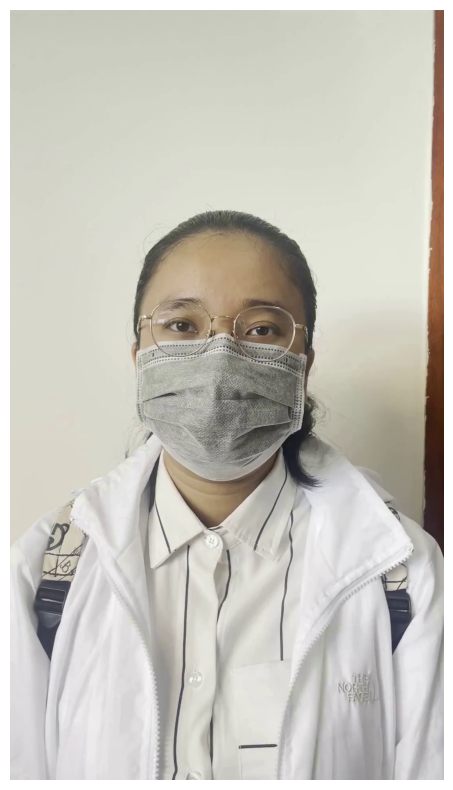

In [50]:
image = cv2.imread('/home/vietlq4/zaloaichallenge/zaloai/train/videos/11/img_00000.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

(224, 224, 3)


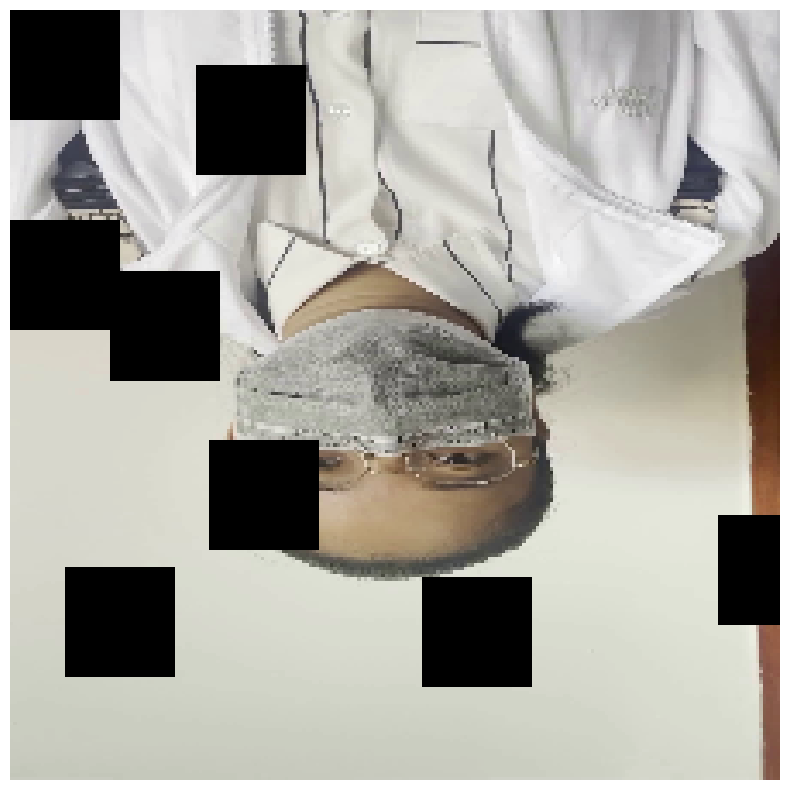

In [96]:
from albumentations.pytorch.transforms import ToTensorV2
transform = A.Compose([
        ## RandomSizedCrop not working for some reason. I'll post a thread for this issue soon.
        ## Any help or suggestions are appreciated.
        # A.RandomSizedCrop(min_max_height=(224, 224), height=224, width=224, p=0.5),
#         A.RandomSizedCrop(min_max_height=(300, 1000), height=1000, width=1000, p=0.5),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                 val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       contrast_limit=0.2, p=0.9),
        ],p=0.9),
        A.JpegCompression(quality_lower=85, quality_upper=95, p=0.2),
        A.OneOf([
            A.Blur(blur_limit=3, p=1.0),
            A.MedianBlur(blur_limit=3, p=1.0)
            ],p=0.1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.Resize(height=224, width=224, p=1),
        A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),

        ],
)
# random.seed(42) 
augmented_image = transform(image=image)['image']
print(augmented_image.shape)
visualize(augmented_image)